In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [87]:
df = pd.read_excel("C://Users//LENOVO//Downloads//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y
# df = df.astype({'y':'int'})
df = df.set_index('date')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
date,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [88]:
data = df.loc[(df['kode_des']==431) & (df['kode_org']==256)]
data = data.groupby(['date'])['y'].sum()
data = pd.DataFrame(data)
data

,y
date,
2020-11-18,21891600.0
2020-11-25,27364500.0
2020-12-02,16418700.0
2020-12-16,1370000.0
2020-12-27,5472900.0
...,...
2023-03-01,77753000.0
2023-03-08,41867000.0
2023-03-15,23924000.0


In [89]:
n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                        y
date                   
2021-07-14   82187400.0
2021-08-04   88830400.0
2022-06-15   86126400.0
2022-08-10  107658000.0
Outliers ke- 2 :                       y
date                  
2022-05-19  75360600.0
2022-08-03  75360600.0
2022-08-31  80743500.0
2023-03-01  77753000.0
Min - Max Value : 486000.0 - 71772000.0


,y
date,
2020-11-18,21891600.0
2020-11-25,27364500.0
2020-12-02,16418700.0
2020-12-16,1370000.0
2020-12-27,5472900.0
...,...
2023-02-22,35886000.0
2023-03-08,41867000.0
2023-03-15,23924000.0


In [90]:
print(f"start date: {min(data.index)}, end date: {max(data.index)}")
data = data.asfreq('d')
data = data.interpolate(method='linear')
data = data.astype({'y':'int'})
# data = data.astype({'y':'int'})
print(f'Number of rows with missing values: {data.isnull().mean()}')
data

start date: 2020-11-18 00:00:00, end date: 2023-03-29 00:00:00
Number of rows with missing values: y    0.0
dtype: float64


,y
date,
2020-11-18,21891600
2020-11-19,22673442
2020-11-20,23455285
2020-11-21,24237128
2020-11-22,25018971
...,...
2023-03-25,51265714
2023-03-26,50411285
2023-03-27,49556857


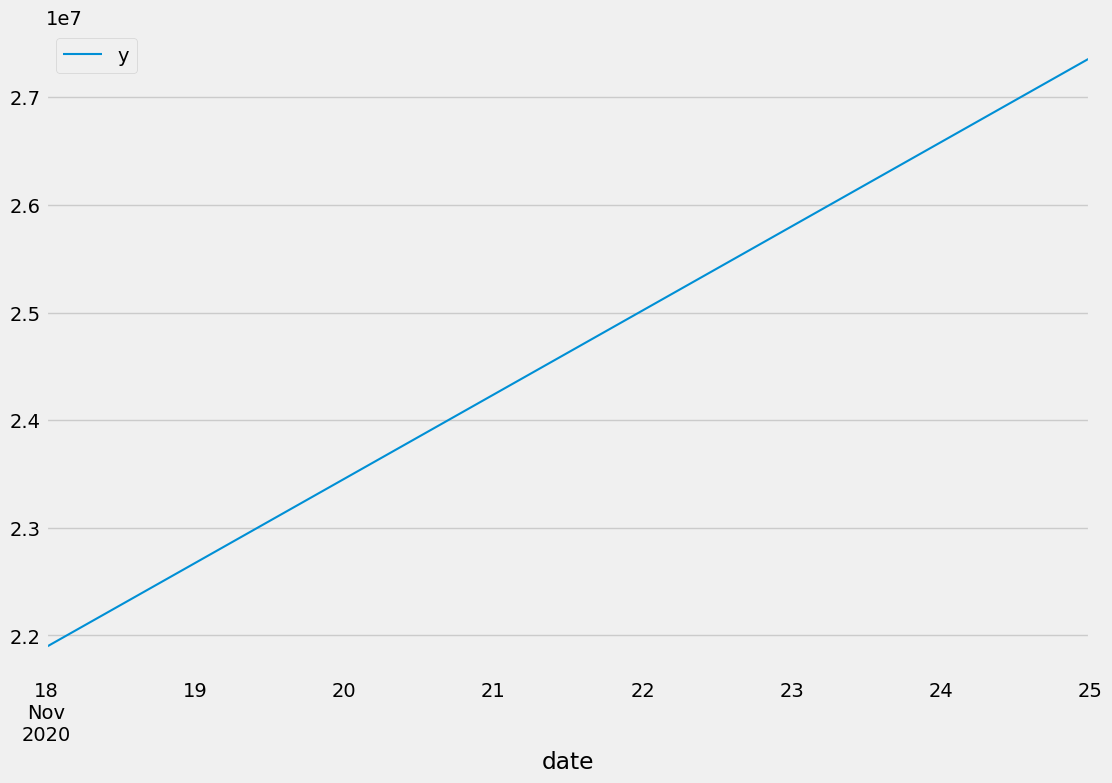

In [91]:
revenue_plot =data['y'].iloc[0:8].plot(
    figsize=(12,8),
    legend=True,
)

In [92]:
unscaled = data['y'].values.reshape(len(data['y']),1)
scaler = StandardScaler()
scaler.fit(unscaled)
scaled = scaler.transform(unscaled)
data['y'] = scaled
data['y']

date
2020-11-18   -0.175790
2020-11-19   -0.120800
2020-11-20   -0.065809
2020-11-21   -0.010818
2020-11-22    0.044173
                ...   
2023-03-25    1.890235
2023-03-26    1.830139
2023-03-27    1.770042
2023-03-28    1.709946
2023-03-29    1.649850
Freq: D, Name: y, Length: 862, dtype: float64

In [93]:
# data['y'] = scaler.inverse_transform(data['y'].values.reshape(len(data['y']),1))
# data['y']

Train dates : 2020-11-18 00:00:00 --- 2023-03-24 00:00:00  (n=857)
Test dates  : 2023-03-25 00:00:00 --- 2023-03-29 00:00:00  (n=5)


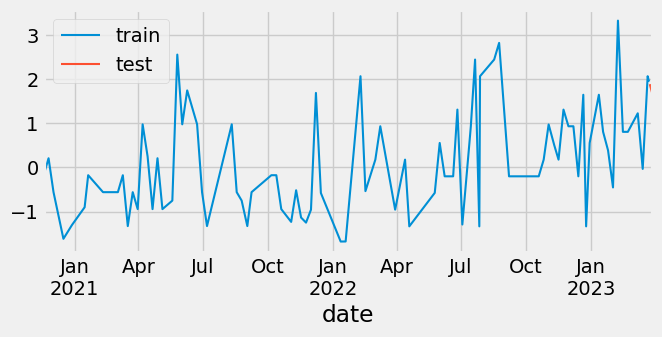

In [94]:
steps = 5
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [95]:
import warnings
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 3)

# Ignore the convergence warnings
warnings.filterwarnings("ignore")

# Grid search over all combinations of p, d, and q
best_rmse, best_order = float('inf'), None
for p, d, q in itertools.product(p_values, d_values, q_values):
        print(p,d,q)

        # Fit the ARIMA model to the training data
        model = ARIMA(data_train['y'].values,order=(p,q,d))
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
        predictions.index = data_test.index


        # Calculate the RMSE of the predictions
        rmse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )
        print(rmse)

        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)

0 0 0
3.1769561051537343
0 0 1
0.039726988621041584
0 0 2
1.8798586065077833e-14
0 1 0
2.5949855320843334
0 1 1
0.03823609639469776
0 1 2
0.07264223922934923
0 2 0
2.151780847447061
0 2 1
0.020834946194471654
0 2 2
0.04131320042170798
1 0 0
0.006777338718962927
1 0 1
0.025032765407747726
1 0 2
1.879648557327225e-14
1 1 0
0.0005856023576439721
1 1 1
0.0241065742357967
1 1 2
0.027057477249708268
1 2 0
0.004434511007911778
1 2 1
0.01368300430356284
1 2 2
0.025984717914285527
2 0 0
0.011840017901435098
2 0 1
0.019497233700704275
2 0 2
0.017454969352253817
2 1 0
0.026008991815538052
2 1 1
0.018560440047669848
2 1 2
0.020981516793118594
2 2 0
0.03794388349047688
2 2 1
0.01655486022573802
2 2 2
0.025490377995206853
3 0 0
0.03299684207368882
3 0 1
0.01705465946478834
3 0 2
0.03717952706720444
3 1 0
0.03274901969343479
3 1 1
0.00845367960197917
3 1 2
0.018580496300974227
3 2 0
0.026177631028572224
3 2 1
0.013357515080864121
3 2 2
0.02087288345832955
4 0 0
0.03256021730646379
4 0 1
0.00432337251

In [96]:
print(best_rmse,(best_order))
arima_model = ARIMA(data_train['y'].values,order=(best_order))
arima_results = arima_model.fit()
# Output model summary results:
arima_results.summary()

1.879648557327225e-14 (1, 0, 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  857
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 262.137
Date:                Tue, 18 Apr 2023   AIC                           -514.273
Time:                        11:46:10   BIC                           -490.506
Sample:                             0   HQIC                          -505.173
                                - 857                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0344      0.390      0.088      0.930      -0.731       0.800
ar.L1          0.9587      0.012     77.582      0.000       0.935       0.983
ma.L1          0.3877      0.010     38.832      0.000       0.368       0.407
ma.L2          0.2433      0.018     13.880      0.000       0.209       0.278
sigma2         0.0316      0.000     86.866      0.000       0.031       0.032
===================================================================================
Ljung-Box (L1) (Q):                   1.46   Jarque-Bera (JB):           1423012.27
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               8.75   Skew:                             9.29
Prob(H) (two-sided):                  0.00   Kurtosis:                       201.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
y_pred = arima_results.forecast(steps=steps)
print(y_pred)

[1.84641211 1.77432826 1.7025115  1.63365896 1.56764827]


In [98]:
predictions = pd.DataFrame(y_pred,columns=['prediction'])
predictions.index = data_test.index
predictions

,prediction
date,
2023-03-25,1.846412
2023-03-26,1.774328
2023-03-27,1.702512
2023-03-28,1.633659
2023-03-29,1.567648


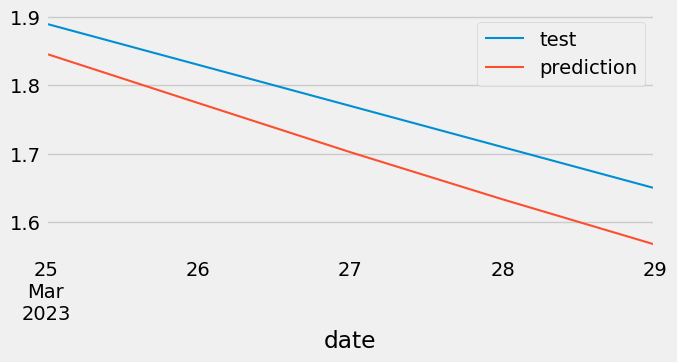

In [99]:
fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(ax=ax, label='test')
predictions['prediction'].plot(ax=ax, label='prediction')
ax.legend();

In [100]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.004434511007911778


In [101]:
data_test['y'] = scaler.inverse_transform(data_test['y'].values.reshape(len(data_test['y']),1))
data_test['y']

date
2023-03-25    51265714.0
2023-03-26    50411285.0
2023-03-27    49556857.0
2023-03-28    48702428.0
2023-03-29    47848000.0
Freq: D, Name: y, dtype: float64

In [102]:
predictions['prediction'] = scaler.inverse_transform(predictions['prediction'].values.reshape(len(predictions['prediction']),1))
predictions['prediction']

date
2023-03-25    5.064266e+07
2023-03-26    4.961779e+07
2023-03-27    4.859672e+07
2023-03-28    4.761780e+07
2023-03-29    4.667928e+07
Freq: D, Name: prediction, dtype: float64

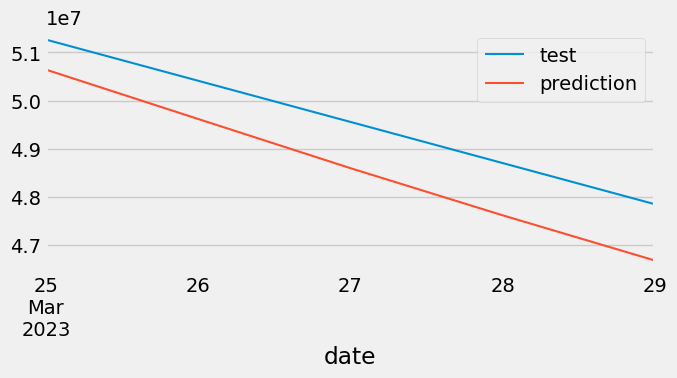

In [103]:
fig, ax = plt.subplots(figsize=(7, 3))
data_test['y'].plot(ax=ax, label='test')
predictions['prediction'].plot(ax=ax, label='prediction')
ax.legend();

In [104]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions['prediction']
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 896404742385.9922


# Hasil

In [106]:
df = pd.read_excel("C://Users//LENOVO//Downloads//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y
# df = df.astype({'y':'int'})
df = df.set_index('date')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
date,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [107]:
import joblib

distinct_route = df[['kode_org', 'kode_des']].drop_duplicates()
pred_results = []
order = 0
for row in distinct_route.values:
    
    order += 1
    print("dataset ke-",order)
    
    #mengambil data set berdasarkan kode org |row[0]| - kode des |row[1]| (Rute)
    data = df.loc[(df['kode_org']==row[0]) & (df['kode_des']==row[1])]
    data = data.groupby(['date'])['y'].sum()
    data = pd.DataFrame(data)
    
    print(f"start date: {min(data.index)}, end date: {max(data.index)}")
    
    #ELIMINATING OUTLIERS WITH IQR
    print("panjang dataset dengan outliers :",len(data))
    n = 0
    x = 1
    while x != 0:   
        n+=1
        q1 = data['y'].quantile(0.25)
        q3 = data['y'].quantile(0.75)
        iqr = q3 - q1
        # identify outliers
        lower_fence = q1 - 1.5*iqr
        upper_fence = q3 + 1.5*iqr
        outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
        x= len(outliers)
        #print("Outliers ke-",n,": ",outliers)
        data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
    print("panjang dataset tanpa outliers :",len(data))
    
    #FILLING DATA GAPS WITH INTERPOLATION
    data = data.asfreq('d')
    data = data.interpolate(method='linear')
    print("Jumlah data setelah interpolasi :",len(data))
    data = data.astype({'y':'int'})
    
    #DATA NORMALIZATION
    unscaled = data['y'].values.reshape(len(data['y']),1)
    scaler = StandardScaler()
    scaler.fit(unscaled)
    scaled = scaler.transform(unscaled)
    data['y'] = scaled
    data['y']    
    
    #SPLIT DATA BUAT DAPETIN STEP YANG DIBUTUHIN BUAT PREDICT CURRENT TIME
    sum_data = len(data)
    today = datetime.date.today()
    today_with_timestamp = datetime.datetime.combine(today, datetime.time.min)
    max_date = data.index.max()
    new_row = pd.DataFrame({'date': today_with_timestamp, 'y': [None], 'org': [None], 'kode_org': [None], 'des': [None], 'kode_des': [None]})
    new_row = new_row.set_index('date')
    data = pd.concat([data, new_row], axis=0)
    data = data.asfreq('d')
    sum_timeline = len(data)
    steps = sum_timeline-sum_data
    data_train = data[:-steps]
    
    #VALIDASI APAKAH DATA BISA DI SPLIT UNTUK GRID SEARCH ATAUT TIDAK
     #based on data priuk-batam kalau ga bisa grid search 
#     if len(data)>steps:
#         data_train_HPO = data_train[:-steps]
#         data_test_HPO  = data_train[-steps:]
#         print(f"Train dates : {data_train_HPO.index.min()} --- {data_train_HPO.index.max()}  (n={len(data_train_HPO)})")
#         print(f"Test dates  : {data_test_HPO.index.min()} --- {data_test_HPO.index.max()}  (n={len(data_test_HPO)})")
        
#         #GRID SEARCH untuk HPO
#         p_values = range(0, 2)
#         d_values = range(0, 3)
#         q_values = range(0, 3)
        
#         warnings.filterwarnings("ignore")
        
#         best_rmse, best_order = float('inf'), None
#         for p, d, q in itertools.product(p_values, d_values, q_values):
#                 # Fit the ARIMA model to the training data
#                 model = ARIMA(data_train_HPO['y'].values,order=(p,q,d))
#                 model_fit = model.fit()
#                 # Make predictions on the test data
#                 predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
#                 predictions.index = data_test_HPO.index
#                 # Calculate the RMSE of the predictions
#                 rmse = mean_squared_error(
#                         y_true = data_test_HPO['y'],
#                         y_pred = predictions['prediction']
#                     )
#                 print("{p:",p,"d:",d,"q:",q,"rmse:",rmse,"}")
#                 # Check if this is the best model so far
#                 if rmse < best_rmse:
#                     best_rmse = rmse
#                     best_order = (p, d, q)
#         print(f"Best Score : {best_rmse} --- (Best Order={best_order})")
    try:
        best_order = (1,0,2)
        #fit forecaster
        arima_model = ARIMA(data_train['y'].values,order=(best_order))
        arima_results = arima_model.fit()

        #predict result
        y_pred = arima_results.forecast(steps=steps)
        predictions = pd.DataFrame(y_pred,columns=['prediction'])
        predictions.index = data_test.index
        predictions['prediction'] = scaler.inverse_transform(predictions['prediction'].values.reshape(len(predictions['prediction']),1))
        this_result = [today_with_timestamp,row[0],row[1],predictions['prediction']]
        pred_results.append(this_result)
        print("{res:",this_result,"}")
        # define the file name you want to save the model as
        filename = (f"C://Users//LENOVO//Downloads//Revenue_OD_ARIMA/{row[0]}_{row[1]}.sav")

        # use joblib.dump() to save the model to disk
        joblib.dump(arima_model, filename)
    except: #klo prediksi gagal karena kekurangan jumlah data , yang di pake adalah satu-satunya data yang ada di OD tersebut
        print("Can't Create Model, Not Enough Data")
        data['y'] = scaler.inverse_transform(data['y'].values.reshape(len(data['y']),1))
        this_result = [today_with_timestamp,row[0],row[1],data['y'].values[0]]
        pred_results.append(this_result)
        print("{res:",this_result,"}")


dataset ke- 1
start date: 2020-11-13 00:00:00, end date: 2023-03-31 00:00:00
panjang dataset dengan outliers : 109
panjang dataset tanpa outliers : 104
Jumlah data setelah interpolasi : 869
Can't Create Model, Not Enough Data
{res: [datetime.datetime(2023, 4, 18, 0, 0), 431, 256, 115483600.0] }
dataset ke- 2
start date: 2020-11-17 00:00:00, end date: 2023-04-01 00:00:00
panjang dataset dengan outliers : 136
panjang dataset tanpa outliers : 132
Jumlah data setelah interpolasi : 866
Can't Create Model, Not Enough Data
{res: [datetime.datetime(2023, 4, 18, 0, 0), 431, 974, 578334565.0] }
dataset ke- 3
start date: 2020-11-17 00:00:00, end date: 2023-04-01 00:00:00
panjang dataset dengan outliers : 228
panjang dataset tanpa outliers : 227
Jumlah data setelah interpolasi : 866
Can't Create Model, Not Enough Data
{res: [datetime.datetime(2023, 4, 18, 0, 0), 431, 893, 62591464.0] }
dataset ke- 4
start date: 2020-11-17 00:00:00, end date: 2023-04-01 00:00:00
panjang dataset dengan outliers : 13

In [108]:
revenue_OD = pd.DataFrame(pred_results,columns=['date','org','des','predictions']) 
revenue_OD

,date,org,des,predictions
0,2023-04-18,431,256,115483600.0
1,2023-04-18,431,974,578334565.0
2,2023-04-18,431,893,62591464.0
3,2023-04-18,431,971,361741000.0
4,2023-04-18,431,975,101407000.0
...,...,...,...,...
861,2023-04-18,688,971,13972652.0
862,2023-04-18,322,714,740777.0
863,2023-04-18,688,808,986032.0
864,2023-04-18,714,246,497116.0


In [ ]:
distinct_route = df[['kode_org', 'kode_des']].drop_duplicates()
pred_results = []
order = 0
for row in distinct_route.values:
    
    order += 1
    print("dataset ke-",order)
    
    #mengambil data set berdasarkan kode org |row[0]| - kode des |row[1]| (Rute)
    data = df.loc[(df['kode_org']==row[0]) & (df['kode_des']==row[1])]
    data = data.groupby(['date'])['y'].sum()
    data = pd.DataFrame(data)
    
    print(f"start date: {min(data.index)}, end date: {max(data.index)}")
    
    #ELIMINATING OUTLIERS WITH IQR
    print("panjang dataset dengan outliers :",len(data))
    n = 0
    x = 1
    while x != 0:   
        n+=1
        q1 = data['y'].quantile(0.25)
        q3 = data['y'].quantile(0.75)
        iqr = q3 - q1
        # identify outliers
        lower_fence = q1 - 1.5*iqr
        upper_fence = q3 + 1.5*iqr
        outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
        x= len(outliers)
        #print("Outliers ke-",n,": ",outliers)
        data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
    print("panjang dataset tanpa outliers :",len(data))
    
    #FILLING DATA GAPS WITH INTERPOLATION
    data = data.asfreq('d')
    data = data.interpolate(method='linear')
    print("Jumlah data setelah interpolasi :",len(data))
    data = data.astype({'y':'int'})
    
    #DATA NORMALIZATION
    unscaled = data['y'].values.reshape(len(data['y']),1)
    scaler = StandardScaler()
    scaler.fit(unscaled)
    scaled = scaler.transform(unscaled)
    data['y'] = scaled
    data['y']    
    
    #SPLIT DATA BUAT DAPETIN STEP YANG DIBUTUHIN BUAT PREDICT CURRENT TIME
    sum_data = len(data)
    today = datetime.date.today()
    today_with_timestamp = datetime.datetime.combine(today, datetime.time.min)
    max_date = data.index.max()
    new_row = pd.DataFrame({'date': today_with_timestamp, 'y': [None], 'org': [None], 'kode_org': [None], 'des': [None], 'kode_des': [None]})
    new_row = new_row.set_index('date')
    data = pd.concat([data, new_row], axis=0)
    data = data.asfreq('d')
    sum_timeline = len(data)
    steps = sum_timeline-sum_data
    data_train = data[:-steps]
    
    #VALIDASI APAKAH DATA BISA DI SPLIT UNTUK GRID SEARCH ATAUT TIDAK
     #based on data priuk-batam kalau ga bisa grid search 
    if len(data)>steps:
        data_train_HPO = data_train[:-steps]
        data_test_HPO  = data_train[-steps:]
        print(f"Train dates : {data_train_HPO.index.min()} --- {data_train_HPO.index.max()}  (n={len(data_train_HPO)})")
        print(f"Test dates  : {data_test_HPO.index.min()} --- {data_test_HPO.index.max()}  (n={len(data_test_HPO)})")
        
        #GRID SEARCH untuk HPO
        p_values = range(0, 6)
        d_values = range(0, 3)
        q_values = range(0, 3)
        
        warnings.filterwarnings("ignore")
        
        best_rmse, best_order = float('inf'), None
        for p, d, q in itertools.product(p_values, d_values, q_values):
                # Fit the ARIMA model to the training data
                model = ARIMA(data_train_HPO['y'].values,order=(p,q,d))
                model_fit = model.fit()
                # Make predictions on the test data
                predictions = pd.DataFrame(model_fit.forecast(steps=steps),columns=['prediction'])
                predictions.index = data_test_HPO.index
                # Calculate the RMSE of the predictions
                rmse = mean_squared_error(
                        y_true = data_test_HPO['y'],
                        y_pred = predictions['prediction']
                    )
                print("{p:",p,"d:",d,"q:",q,"rmse:",rmse,"}")
                # Check if this is the best model so far
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = (p, d, q)
        print(f"Best Score : {best_rmse} --- (Best Order={best_order})")
    try:
        best_order = (1,0,2)
        #fit forecaster
        arima_model = ARIMA(data_train['y'].values,order=(best_order))
        arima_results = arima_model.fit()

        #predict result
        y_pred = arima_results.forecast(steps=steps)
        predictions = pd.DataFrame(y_pred,columns=['prediction'])
        predictions.index = data_test.index
        predictions['prediction'] = scaler.inverse_transform(predictions['prediction'].values.reshape(len(predictions['prediction']),1))
        this_result = [today_with_timestamp,row[0],row[1],predictions['prediction']]
        pred_results.append(this_result)
        print("{res:",this_result,"}")
        # define the file name you want to save the model as
        filename = (f"C://Users//LENOVO//Downloads//Revenue_OD_ARIMA/{row[0]}_{row[1]}.sav")

        # use joblib.dump() to save the model to disk
        joblib.dump(arima_model, filename)
    except: #klo prediksi gagal karena kekurangan jumlah data , yang di pake adalah satu-satunya data yang ada di OD tersebut
        print("Can't Create Model, Not Enough Data")
        data['y'] = scaler.inverse_transform(data['y'].values.reshape(len(data['y']),1))
        this_result = [today_with_timestamp,row[0],row[1],data['y'].values[0]]
        pred_results.append(this_result)
        print("{res:",this_result,"}")

dataset ke- 1
start date: 2020-11-13 00:00:00, end date: 2023-03-31 00:00:00
panjang dataset dengan outliers : 109
panjang dataset tanpa outliers : 104
Jumlah data setelah interpolasi : 869
Train dates : 2020-11-13 00:00:00 --- 2023-03-13 00:00:00  (n=851)
Test dates  : 2023-03-14 00:00:00 --- 2023-03-31 00:00:00  (n=18)
{p: 0 d: 0 q: 0 rmse: 1.6633916212168025 }
{p: 0 d: 0 q: 1 rmse: 0.7120463607174049 }
{p: 0 d: 0 q: 2 rmse: 0.07532170438251903 }
{p: 0 d: 1 q: 0 rmse: 1.516236726846884 }
{p: 0 d: 1 q: 1 rmse: 0.6433168934730848 }
{p: 0 d: 1 q: 2 rmse: 0.07532170438250745 }
{p: 0 d: 2 q: 0 rmse: 1.3993345624318958 }
{p: 0 d: 2 q: 1 rmse: 0.6847951999845892 }
{p: 0 d: 2 q: 2 rmse: 0.07532170438252332 }
{p: 1 d: 0 q: 0 rmse: 0.4395304544209837 }
{p: 1 d: 0 q: 1 rmse: 0.4484228113005049 }
{p: 1 d: 0 q: 2 rmse: 0.07532170438252689 }
{p: 1 d: 1 q: 0 rmse: 0.3029887904550405 }
{p: 1 d: 1 q: 1 rmse: 0.4808020877786323 }
{p: 1 d: 1 q: 2 rmse: 0.07532170437785002 }
{p: 1 d: 2 q: 0 rmse: 0.2327